In [1]:
import numpy
import pandas as pd
import csv
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
debate_transcripts = pd.read_csv('/content/drive/MyDrive/NLP/eu_debate_transcripts_translated.csv')

In [3]:
statements = pd.read_csv('/content/drive/MyDrive/NLP/statements.csv')

In [23]:
# Compare text length in characters
debate_transcripts['length'] = debate_transcripts['translated_text'].astype(str).str.len()
debate_transcripts['source'] = 'Real'

statements['length'] = statements['statement'].astype(str).str.len()
statements['source'] = statements['provider'].str.capitalize()  # e.g., "Chatgpt", "Deepseek"

# Combine datasets
df_lengths = pd.concat([
    debate_transcripts[['source', 'length']],
    statements[['source', 'length']]
], ignore_index=True)

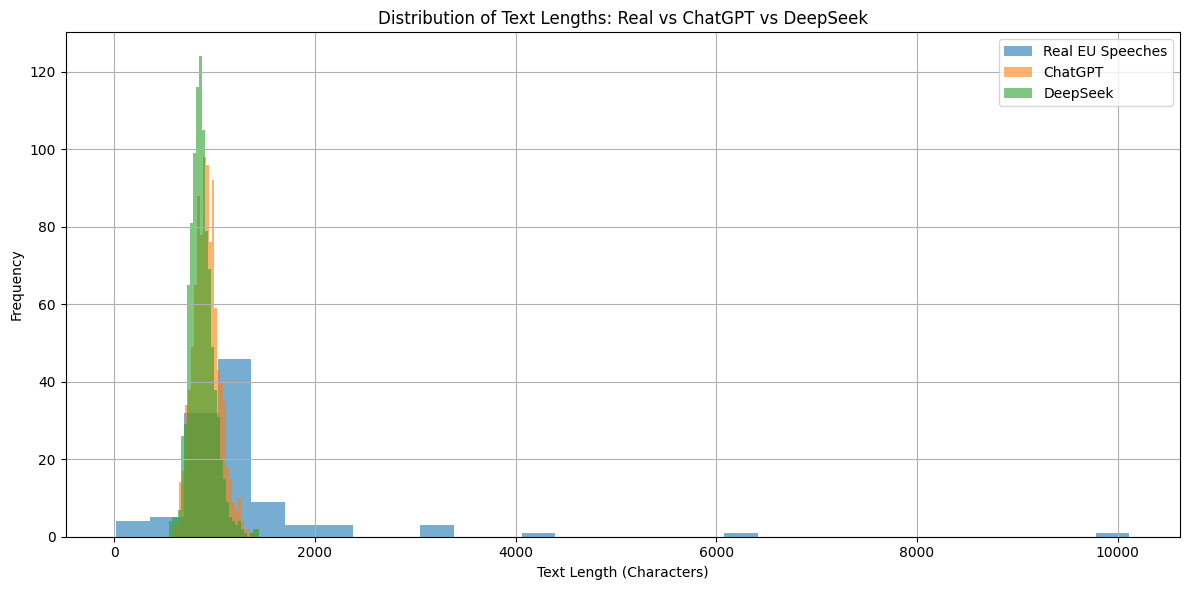

In [26]:
# Histogram of text lengths
plt.figure(figsize=(12, 6))

# Real EU speeches
plt.hist(debate_transcripts['length'], bins=30, alpha=0.6, label='Real EU Speeches')

# ChatGPT-generated statements
chatgpt = statements[statements['provider'].str.lower() == 'chatgpt']
plt.hist(chatgpt['length'], bins=30, alpha=0.6, label='ChatGPT')

# DeepSeek-generated statements
deepseek = statements[statements['provider'].str.lower() == 'deepseek']
plt.hist(deepseek['length'], bins=30, alpha=0.6, label='DeepSeek')

plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths: Real vs ChatGPT vs DeepSeek')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
#Download Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Function to tokenize and clean text
def get_word_counts(texts, stopwords=None):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        if stopwords:
            tokens = [t for t in tokens if t not in stopwords]
        words.extend(tokens)
    return Counter(words)

In [28]:
# Separate ChatGPT and DeepSeek texts
chatgpt = statements[statements['provider'].str.lower() == 'chatgpt']
deepseek = statements[statements['provider'].str.lower() == 'deepseek']

In [29]:
# Get word counts for each source
real_words = get_word_counts(debate_transcripts['translated_text'], stop_words)
chatgpt_words = get_word_counts(chatgpt['statement'], stop_words)
deepseek_words = get_word_counts(deepseek['statement'], stop_words)

In [30]:
# Total word counts
real_total = sum(real_words.values())
chatgpt_total = sum(chatgpt_words.values())
deepseek_total = sum(deepseek_words.values())

In [31]:
# Top 20 words from each
real_top20 = real_words.most_common(20)
chatgpt_top20 = chatgpt_words.most_common(20)
deepseek_top20 = deepseek_words.most_common(20)

In [32]:
# Convert to DataFrames
df_real_top = pd.DataFrame(real_top20, columns=['word', 'count_real'])
df_chatgpt_top = pd.DataFrame(chatgpt_top20, columns=['word', 'count_chatgpt'])
df_deepseek_top = pd.DataFrame(deepseek_top20, columns=['word', 'count_deepseek'])

In [33]:
# Normalize to percentages
df_real_top['freq_real'] = df_real_top['count_real'] / real_total * 100
df_chatgpt_top['freq_chatgpt'] = df_chatgpt_top['count_chatgpt'] / chatgpt_total * 100
df_deepseek_top['freq_deepseek'] = df_deepseek_top['count_deepseek'] / deepseek_total * 100

In [34]:
# Merge on word
df_merged = pd.merge(df_real_top[['word', 'freq_real']],
                     df_chatgpt_top[['word', 'freq_chatgpt']],
                     on='word', how='outer')

df_merged = pd.merge(df_merged,
                     df_deepseek_top[['word', 'freq_deepseek']],
                     on='word', how='outer').fillna(0)

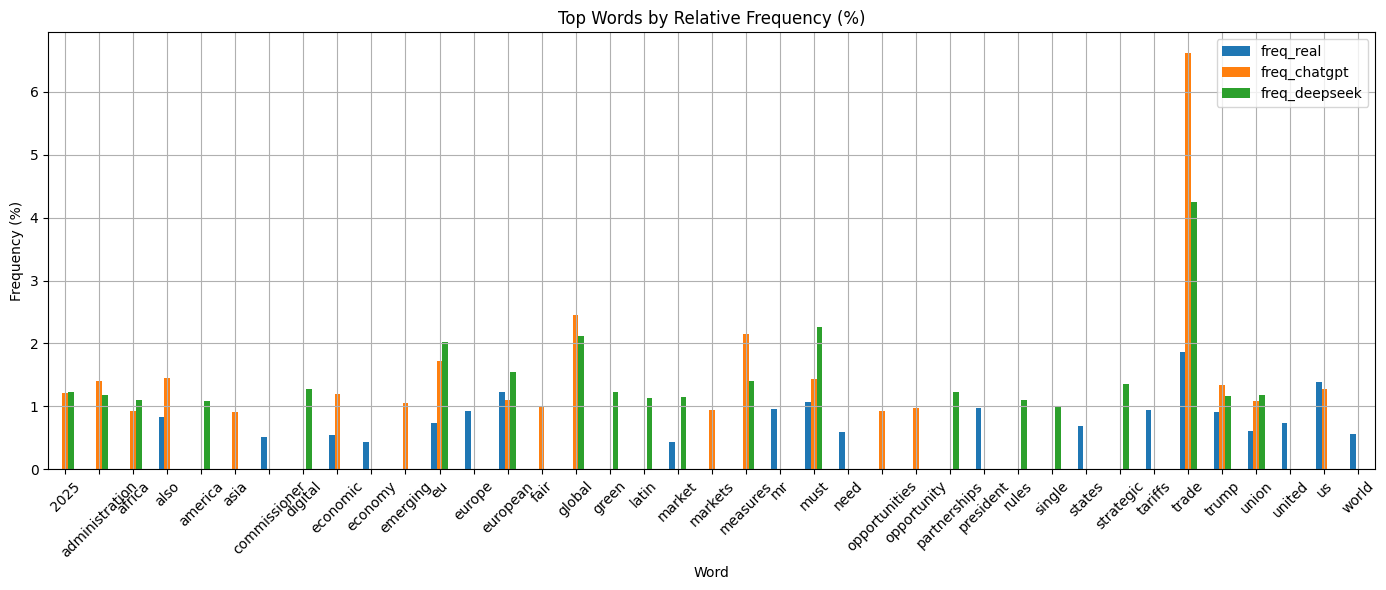

In [35]:
# Plot
df_merged.set_index('word').plot(kind='bar', figsize=(14, 6), title="Top Words by Relative Frequency (%)")
plt.ylabel("Frequency (%)")
plt.xlabel("Word")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Compute TTR
def type_token_ratio(text):
    words = str(text).lower().split()
    return len(set(words)) / len(words) if words else 0

debate_transcripts['ttr'] = debate_transcripts['translated_text'].apply(type_token_ratio)
debate_transcripts['source'] = 'Real EU Speeches'

statements['ttr'] = statements['statement'].apply(type_token_ratio)
statements['source'] = statements['provider'].str.capitalize()

# Combine for comparison
df_ttr = pd.concat([
    debate_transcripts[['source', 'ttr']],
    statements[['source', 'ttr']]
])

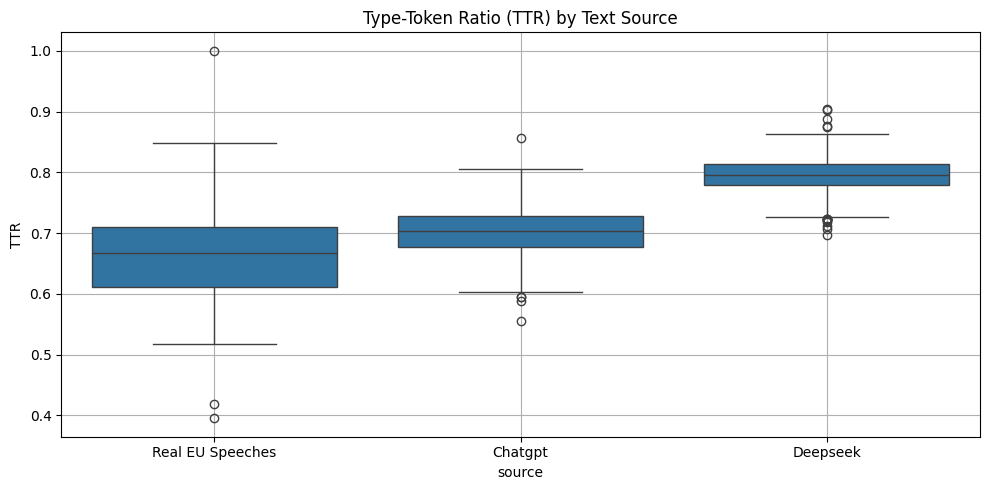

In [21]:
# TTR Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_ttr, x='source', y='ttr')
plt.title("Type-Token Ratio (TTR) by Text Source")
plt.ylabel("TTR")
plt.grid(True)
plt.tight_layout()
plt.show()

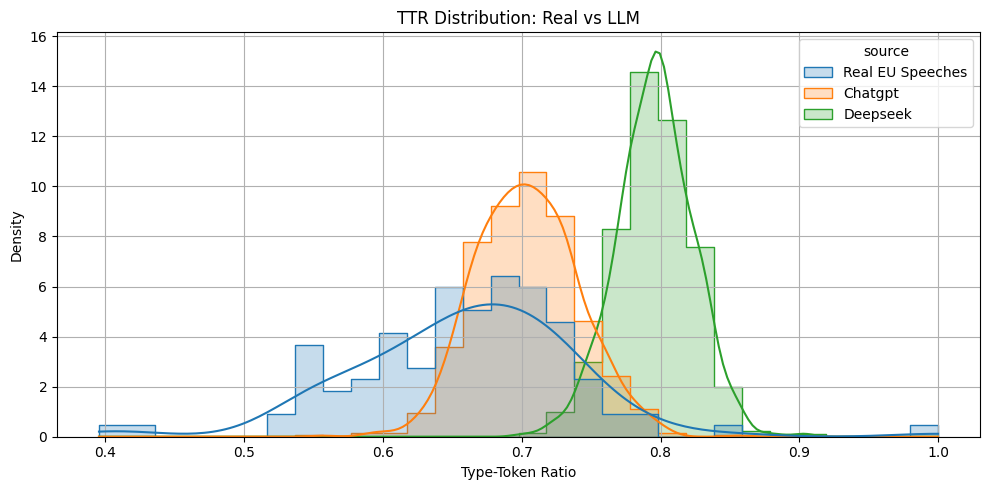

In [22]:
# TTR Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df_ttr, x='ttr', hue='source', kde=True, bins=30, element='step', stat='density', common_norm=False)
plt.title("TTR Distribution: Real vs LLM")
plt.xlabel("Type-Token Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()